# Create subsets and file lists from ETRI Activity 3D

In [35]:
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

DATASET_NAME = 'EtriActivity3D'
SOURCE_FOLDER = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D/all_videos'
DEST_FOLDER = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D'
SUBSETS = [0.8, 0.1, 0.1]
SEED = 777
N_CLASSES = 55

## Load file names and classes:

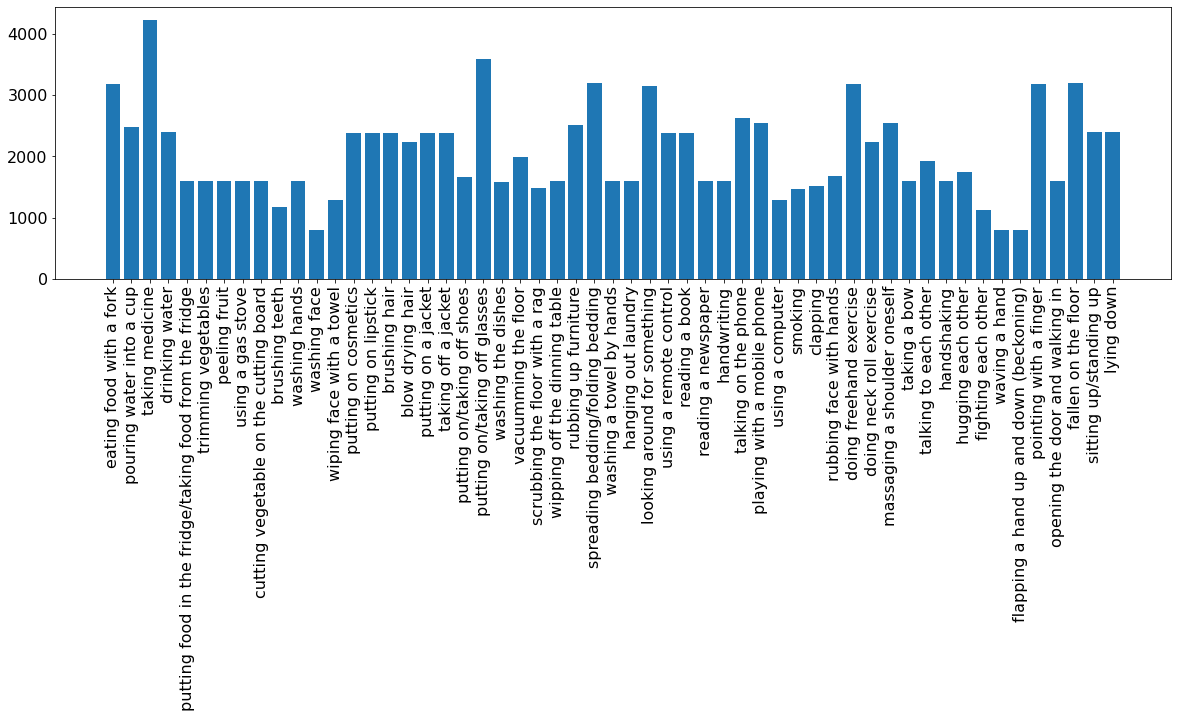

In [33]:
labels = [x.strip() for x in open("label_map_EtriActivity3D.txt").readlines()]

list_files = []
list_classes = []

for root, dirs, files in os.walk(SOURCE_FOLDER, topdown=False):
    for name in files:
        list_files.append(os.path.join(root, name))
        list_classes.append(int(name.partition("_")[0][1:]))

hist = np.histogram(list_classes, bins=N_CLASSES)[0]
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['font.size'] = 16
plt.bar(height=hist, x=labels)
plt.xticks(labels, rotation='vertical')
plt.show()

## Split into train-val-test sets

In [78]:
x_train, x_rem, y_train, y_rem = train_test_split(list_files, list_classes, train_size=SUBSETS[0], random_state=SEED)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=SUBSETS[2]/(SUBSETS[1]+SUBSETS[2]), random_state=SEED+1)

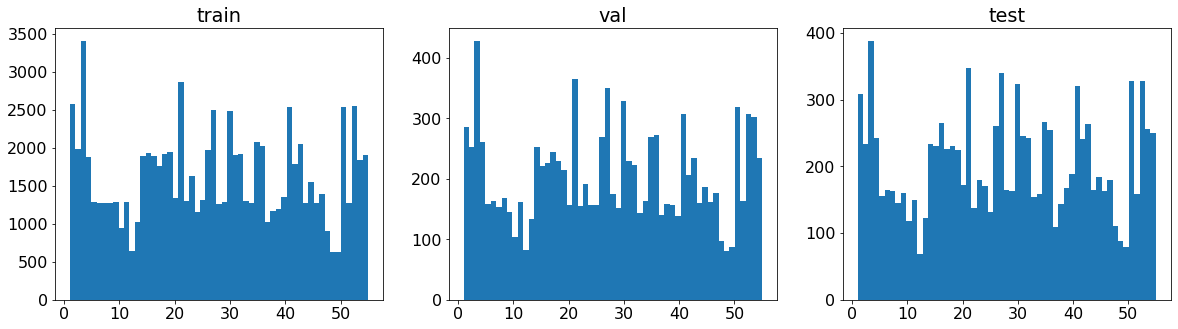

In [79]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['font.size'] = 16
f, axarr = plt.subplots(1,3)
axarr = axarr.flatten()
i = 0

axarr[i].title.set_text('train')
axarr[i].hist(y_train, bins=N_CLASSES)
i += 1

axarr[i].title.set_text('val')
axarr[i].hist(y_valid, bins=N_CLASSES)
i += 1

axarr[i].title.set_text('test')
axarr[i].hist(y_test, bins=N_CLASSES)
plt.show()

## Move videos and write file lists

In [97]:
def move_videos(file_list, class_list, split):
    
    # create split dir
    split_dir = os.path.join(DEST_FOLDER, split)
    os.mkdir(split_dir)
    
    # file name and path
    f_name = DATASET_NAME+'_'+split+'_video.txt'
    f_path = os.path.join(DEST_FOLDER, f_name)
    
    with open(f_path, 'w') as f:
        for file, label in zip(file_list, class_list):
            
            # Write to file
            # Classes start at 0!
            f.write(os.path.basename(file) + ' ' + str(label-1) + '\n')
            
            # Move video
            # shutil.move(file, split_dir)

In [96]:
move_videos(x_train, y_train, 'train')
move_videos(x_valid, y_valid, 'val')
move_videos(x_test, y_test, 'test')

## Split and move skeleton files

In [13]:
RGB_DIR = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D'
SRC_SKELETON_DIR = 'F:/ETRI-Activity3D/Skeleton/Skeleton'
DST_SKELETON_DIR = 'F:/ETRI-Activity3D/Skeleton/EtriActivity3D'

In [15]:
def split_skeleton(split):
    
    count_no_skeleton = 0
    list_no_skeleton = []
    dst_split_dir = os.path.join(DST_SKELETON_DIR, split)
    os.mkdir(dst_split_dir)
    
    for file in os.listdir(os.path.join(RGB_DIR, split)):
        name = file[:-3] + 'csv'
        
        # Move CSV
        if os.path.exists(os.path.join(SRC_SKELETON_DIR, name)):
            shutil.move(os.path.join(SRC_SKELETON_DIR, name), dst_split_dir)
        else: 
            list_no_skeleton.append(file)
    
    print('Split:', split, ' Videos with no skeleton: ', len(list_no_skeleton), '\n', list_no_skeleton)

In [16]:
split_skeleton('train')
split_skeleton('val')
split_skeleton('test')

Split: train  Videos with no skeleton:  0 
 []
Split: val  Videos with no skeleton:  1 
 ['A055_P074_G003_C008.mp4']
Split: test  Videos with no skeleton:  0 
 []


**Note:** A055_P074_G003_C008.csv does not exist, but there is a A055_P074_G003_C007.csv.

Manually moved this A055_P074_G003_C007.csv to validation.

## K-Cross Validation

In [36]:
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

DATASET_NAME = 'EtriActivity3D'
VIDEOS_FOLDER = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D/all_videos'
DEST_FOLDER = 'F:/ETRI-Activity3D/RGB Videos/EtriActivity3D'
K = 5
SEED = 777
N_CLASSES = 55

Load file names and classes:

In [37]:
list_files = []
list_classes = []

for root, dirs, files in os.walk(VIDEOS_FOLDER, topdown=False):
    for name in files:
        list_files.append(os.path.join(root, name))
        list_classes.append(int(name.partition("_")[0][1:]))

In [38]:
def files_cross_validation(train_set, test_set, k):
    file_cross_validation(train_set, os.path.join(DEST_FOLDER, DATASET_NAME+'_train_k' + str(k) + '_video.txt'))
    file_cross_validation(test_set, os.path.join(DEST_FOLDER, DATASET_NAME+'_test_k' + str(k) + '_video.txt'))
            
def file_cross_validation(cv_set, cv_name):
    with open(cv_name, 'w') as f:
        for idx in cv_set:
            
            # Get name of file and label
            file = list_files[idx]
            label = list_classes[idx]
            
            # Write to file
            # Classes start at 0!
            f.write(os.path.basename(file) + ' ' + str(label-1) + '\n')

In [39]:
random.seed(SEED)
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

k_count = 1
for train, test in kf.split(list_files):
    random.shuffle(train)
    random.shuffle(test)
    files_cross_validation(train, test, k_count)
    k_count += 1

## Class Id and names:

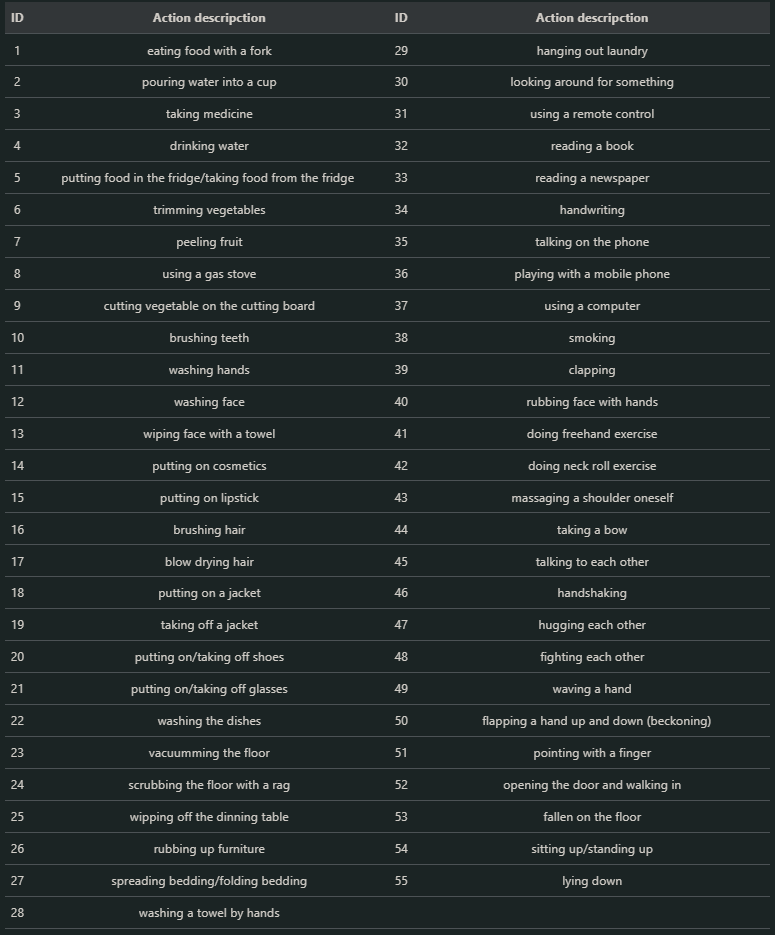